Step 1: Import and Setup

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


Step 2: Load and Preprocess Dataset

In [ ]:
# Directory of training and test data
train_path = '/home/tauhid/llm_network_intrusion/nsl-kdd/KDDTrain+.csv'
test_path = '/home/tauhid/llm_network_intrusion/nsl-kdd/KDDTest+.csv'

# Load training data
df = pd.read_csv(train_path, nrows=10000)
df_test = pd.read_csv(test_path, nrows=2500)

# Apply label encoding
for dataset in [df, df_test]:
    dataset['label'] = dataset['label'].apply(lambda x: 0 if x == 'normal' else 1)
    dataset.drop(columns=['difficulty_score'], inplace=True)

df['text'] = df.drop(columns='label').astype(str).agg(', '.join, axis=1)
df_test['text'] = df_test.drop(columns='label').astype(str).agg(', '.join, axis=1)

# Quick overview
print(df.shape)
print(df['label'].value_counts(normalize=True).round(2))
df.head()

(1000, 43)
label
0    0.52
1    0.48
Name: proportion, dtype: float64


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,text
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,"0, tcp, ftp_data, SF, 491, 0, 0, 0, 0, 0, 0, 0..."
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,"0, udp, other, SF, 146, 0, 0, 0, 0, 0, 0, 0, 0..."
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,"0, tcp, private, S0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,"0, tcp, http, SF, 232, 8153, 0, 0, 0, 0, 0, 1,..."
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,"0, tcp, http, SF, 199, 420, 0, 0, 0, 0, 0, 1, ..."


Step 3: Dataset Class

In [3]:
class NIDSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length',
                                  max_length=self.max_length, return_tensors='pt')
        item = {k: v.squeeze() for k, v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

Step 4: Model Setup (Use distilGPT2 + AMP Ready)

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilgpt2"  # faster alternative
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

Step 5: Dataloaders

In [5]:
batch_size = 8

train_dataset = NIDSDataset(df['text'], df['label'], tokenizer)
test_dataset = NIDSDataset(df_test['text'], df_test['label'], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Step 6: Training Loop with _fp16_, _tqdm_, and Checkpoints

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
scaler = torch.cuda.amp.GradScaler()  # AMP scaler
epochs = 10
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    train_preds, train_labels = [], []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(**batch)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=-1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(batch['labels'].cpu().numpy())

    acc = accuracy_score(train_labels, train_preds)
    f1 = f1_score(train_labels, train_preds)
    losses.append(epoch_loss / len(train_loader))

    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    # Save checkpoint
    #torch.save(model.state_dict(), f"model_checkpoint_epoch_{epoch+1}.pt")

/home/tauhid/venv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/tauhid/venv/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]/home/tauhid/venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1 | Loss: 61.4101 | Acc: 0.7820 | F1: 0.7691


Step 7: Plot Loss (optional)

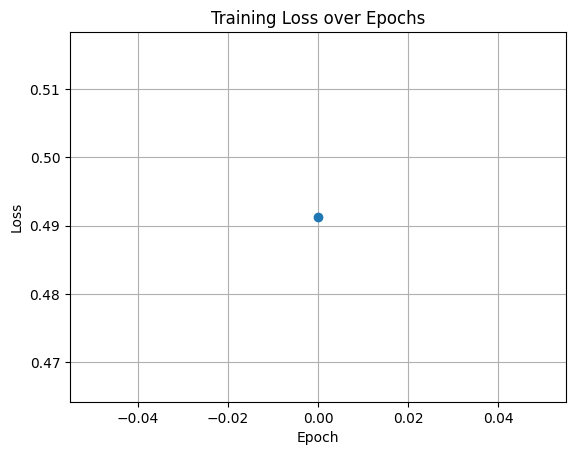

In [7]:
plt.plot(losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Step 8: Evaluation on Test Set

In [8]:
model.eval()
test_preds, test_labels, prob_scores = [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=-1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch['labels'].cpu().numpy())
        prob_scores.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (Anomaly)

# Compute metrics
acc = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
precision_anomaly = precision_score(test_labels, test_preds, pos_label=1)
precision_benign  = precision_score(test_labels, test_preds, pos_label=0)
auroc = roc_auc_score(test_labels, prob_scores)
auprc = average_precision_score(test_labels, prob_scores)
tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
fpr = fp / (fp + tn)

# Print results
print("\n--- Test Evaluation ---")
print(f"Accuracy            : {acc:.4f}")
print(f"Precision (Benign)  : {precision_benign:.4f}")
print(f"Precision (Anomaly) : {precision_anomaly:.4f}")
print(f"Recall              : {recall:.4f}")
print(f"F1 Score            : {f1:.4f}")
print(f"AUROC               : {auroc:.4f}")
print(f"AUPRC               : {auprc:.4f}")
print(f"FPR (False Positive): {fpr:.6f}")


--- Test Evaluation ---
Accuracy            : 0.7640
Precision (Benign)  : 0.6564
Precision (Anomaly) : 0.9655
Recall              : 0.6000
F1 Score            : 0.7401
AUROC               : 0.9371
AUPRC               : 0.9540
FPR (False Positive): 0.027273


Step 9: Identify Incorrect Predictions (Feedback Collection)


_Run inference on the feedback set and collect only those samples that were incorrectly predicted_

In [9]:
# Step 9: Create feedback and evaluation sets if not already available
if 'df_feedback' not in locals() or 'df_eval' not in locals():
    from sklearn.model_selection import train_test_split
    df_feedback, df_eval = train_test_split(df_test, test_size=0.7, random_state=42, stratify=df_test['label'])
    print(f"Created feedback set with {len(df_feedback)} samples and eval set with {len(df_eval)} samples.")
else:
    print("Feedback and eval sets already exist.")


Created feedback set with 75 samples and eval set with 175 samples.


Step 10: Identify Incorrect Predictions in Feedback Set

In [10]:
# Step 10: Collect incorrect predictions from the feedback set
feedback_dataset = NIDSDataset(df_feedback['text'], df_feedback['label'], tokenizer)
feedback_loader = DataLoader(feedback_dataset, batch_size=8)

model.eval()
incorrect_texts, incorrect_labels = [], []

with torch.no_grad():
    for i, batch in enumerate(feedback_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        mismatches = preds != batch['labels']

        indices = range(i * 8, min((i + 1) * 8, len(df_feedback)))
        for j, mismatch in enumerate(mismatches):
            if mismatch:
                idx = list(indices)[j]
                incorrect_texts.append(df_feedback['text'].iloc[idx])
                incorrect_labels.append(df_feedback['label'].iloc[idx])

print(f"Collected {len(incorrect_texts)} incorrect predictions for feedback training.")


Collected 19 incorrect predictions for feedback training.


Step 11: Fine-Tune Model on Mistakes

In [11]:
# Step 11: Fine-tune model using misclassified samples
if incorrect_texts:
    correction_dataset = NIDSDataset(pd.Series(incorrect_texts), pd.Series(incorrect_labels), tokenizer)
    correction_loader = DataLoader(correction_dataset, batch_size=8, shuffle=True)

    model.train()
    for epoch in range(3):
        for batch in correction_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    print("✅ Model fine-tuned on incorrect samples.")
else:
    print("⚠️ No incorrect predictions found. Skipping fine-tuning.")


✅ Model fine-tuned on incorrect samples.


Step 12: Evaluate Model on Evaluation Set

In [12]:
# Step 12: Run updated model on the eval set
eval_dataset = NIDSDataset(df_eval['text'], df_eval['label'], tokenizer)
eval_loader = DataLoader(eval_dataset, batch_size=8)

model.eval()
eval_preds, eval_labels, eval_probs = [], [], []

with torch.no_grad():
    for batch in eval_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=-1)

        eval_preds.extend(preds.cpu().numpy())
        eval_labels.extend(batch['labels'].cpu().numpy())
        eval_probs.extend(probs[:, 1].cpu().numpy())

print("Evaluation complete.")


Evaluation complete.


Step 13: Print Evaluation Metrics After Feedback

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, average_precision_score

acc = accuracy_score(eval_labels, eval_preds)
f1 = f1_score(eval_labels, eval_preds)
recall = recall_score(eval_labels, eval_preds)
precision_anomaly = precision_score(eval_labels, eval_preds, pos_label=1)
precision_benign  = precision_score(eval_labels, eval_preds, pos_label=0)
auroc = roc_auc_score(eval_labels, eval_probs)
auprc = average_precision_score(eval_labels, eval_probs)
tn, fp, fn, tp = confusion_matrix(eval_labels, eval_preds).ravel()
fpr = fp / (fp + tn)

print("\n--- Final Evaluation After Feedback ---")
print(f"Accuracy            : {acc:.4f}")
print(f"Precision (Benign)  : {precision_benign:.4f}")
print(f"Precision (Anomaly) : {precision_anomaly:.4f}")
print(f"Recall              : {recall:.4f}")
print(f"F1 Score            : {f1:.4f}")
print(f"AUROC               : {auroc:.4f}")
print(f"AUPRC               : {auprc:.4f}")
print(f"FPR (False Positive): {fpr:.6f}")



--- Final Evaluation After Feedback ---
Accuracy            : 0.5600
Precision (Benign)  : 0.0000
Precision (Anomaly) : 0.5600
Recall              : 1.0000
F1 Score            : 0.7179
AUROC               : 0.5771
AUPRC               : 0.7201
FPR (False Positive): 1.000000


/home/tauhid/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
